## Seq to Seq LSTM

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, multiply, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model
import pydotplus as pydot

#### Create a dataset

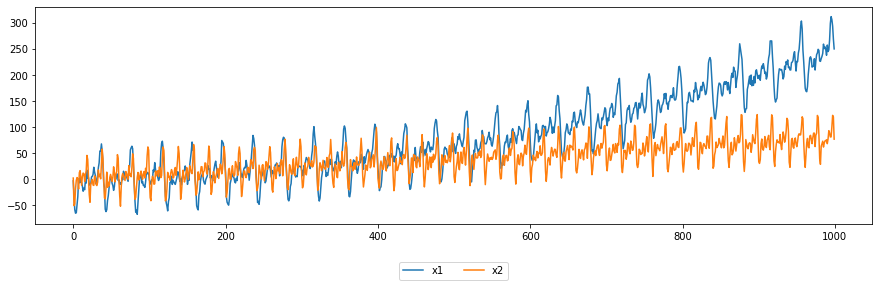

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)

# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))

plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#### Preprocessing

##### 1. Split sequences to 80% train set and 20% test set

In [3]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


##### Detrending

In [4]:
x_index = np.array(range(len(t)))

In [5]:
x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.40860103e-04  1.09486779e-02 -2.96016568e+00]
[ 0.0806673  -0.85077201]


In [6]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

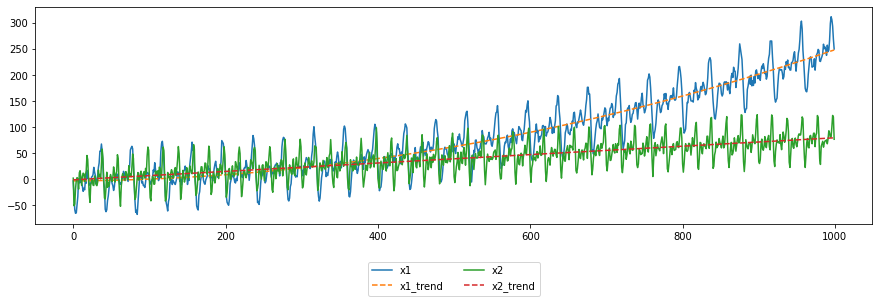

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

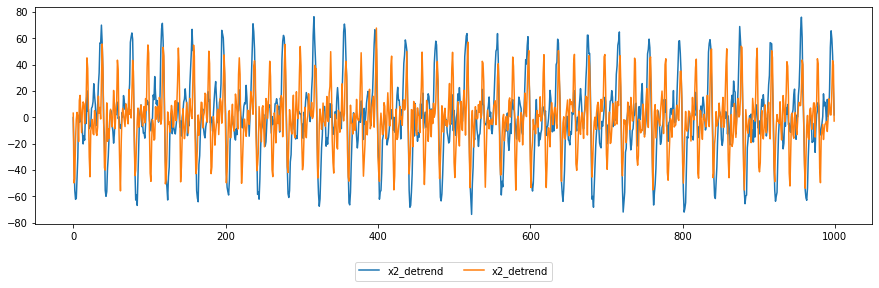

In [8]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#### 3. Combine sequnces

In [9]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[-1.50100781e-01  3.21322961e+00  0.00000000e+00  1.00000000e+00]
 [-2.90907969e+01 -4.97824833e+01  1.00000000e+00  1.00000000e+00]
 [-5.52242985e+01 -4.65230523e+01  2.00000000e+00  1.00000000e+00]
 ...
 [ 4.66847694e+01  4.30969006e+01  9.97000000e+02  0.00000000e+00]
 [ 2.13637561e+01  4.00223907e+01  9.98000000e+02  0.00000000e+00]
 [ 1.88789159e+00 -2.76322051e+00  9.99000000e+02  0.00000000e+00]]


In [10]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[76.4735062144974, 67.86512039290882, 1, 1]


In [11]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[-1.96278147e-03  4.73472911e-02  0.00000000e+00  1.00000000e+00]
 [-3.80403598e-01 -7.33550357e-01  1.00000000e+00  1.00000000e+00]
 [-7.22136348e-01 -6.85522284e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.10469844e-01  6.35037562e-01  9.97000000e+02  0.00000000e+00]
 [ 2.79361535e-01  5.89734321e-01  9.98000000e+02  0.00000000e+00]
 [ 2.46868710e-02 -4.07163576e-02  9.99000000e+02  0.00000000e+00]]


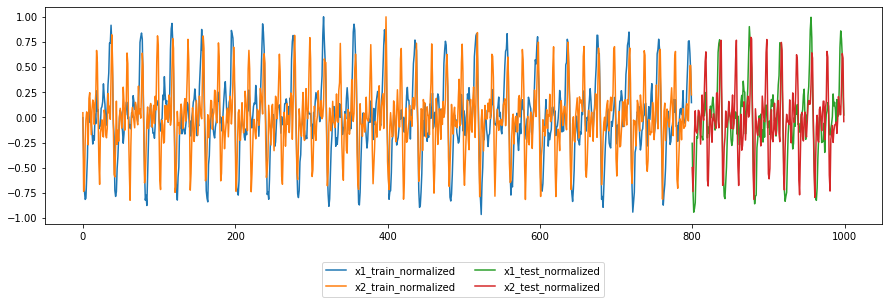

In [12]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#### 5. Truncate

In [13]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [14]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


In [15]:
n_hidden = 100

#### Input layer

In [16]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


#### The encoder LSTM

- **return_sequences=False, return_state=False**: return the last hidden state: state_h
- **return_sequences=True, return_state=False**: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- **return_sequences=False, return_state=True**: return 3 arrays: state_h, state_h, state_c
- **return_sequences=True, return_state=True**: return 3 arrays: stacked hidden states, last state_h, last state_c

In [17]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)

print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [18]:
# Batch normalisation is added because we want to avoid gradient explosion 
# caused by the activation function ELU in the encoder
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

In [19]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, 
               return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [20]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [21]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [24]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [25]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 7s 523ms/step - loss: 3.0670 - mae: 0.9950 - val_loss: 0.1274 - val_mae: 0.2609
Epoch 2/100
5/5 [==============================] - 1s 297ms/step - loss: 0.1738 - mae: 0.3253 - val_loss: 0.1294 - val_mae: 0.2688
Epoch 3/100
5/5 [==============================] - 2s 324ms/step - loss: 0.1283 - mae: 0.2667 - val_loss: 0.1148 - val_mae: 0.2489
Epoch 4/100
5/5 [==============================] - 2s 323ms/step - loss: 0.1207 - mae: 0.2577 - val_loss: 0.1295 - val_mae: 0.2785
Epoch 5/100
5/5 [==============================] - 2s 341ms/step - loss: 0.1148 - mae: 0.2513 - val_loss: 0.1081 - val_mae: 0.2449
Epoch 6/100
5/5 [==============================] - 2s 338ms/step - loss: 0.1114 - mae: 0.2464 - val_loss: 0.1020 - val_mae: 0.2369
Epoch 7/100
5/5 [==============================] - 2s 333ms/step - loss: 0.1088 - mae: 0.2432 - val_loss: 0.0967 - val_mae: 0.2327
Epoch 8/100
5/5 [==============================] - 2s 350ms/step - loss: 0.1045 - m

5/5 [==============================] - 2s 439ms/step - loss: 0.0239 - mae: 0.1150 - val_loss: 0.0149 - val_mae: 0.0969
Epoch 64/100
5/5 [==============================] - 2s 452ms/step - loss: 0.0288 - mae: 0.1256 - val_loss: 0.0154 - val_mae: 0.0985
Epoch 65/100
5/5 [==============================] - 2s 460ms/step - loss: 0.0249 - mae: 0.1181 - val_loss: 0.0163 - val_mae: 0.1003
Epoch 66/100
5/5 [==============================] - 2s 449ms/step - loss: 0.0238 - mae: 0.1144 - val_loss: 0.0152 - val_mae: 0.0958
Epoch 67/100
5/5 [==============================] - 2s 452ms/step - loss: 0.0223 - mae: 0.1119 - val_loss: 0.0145 - val_mae: 0.0947
Epoch 68/100
5/5 [==============================] - 2s 460ms/step - loss: 0.0211 - mae: 0.1090 - val_loss: 0.0137 - val_mae: 0.0908
Epoch 69/100
5/5 [==============================] - 2s 436ms/step - loss: 0.0237 - mae: 0.1131 - val_loss: 0.0166 - val_mae: 0.1005
Epoch 70/100
5/5 [==============================] - 2s 443ms/step - loss: 0.0219 - mae: 0

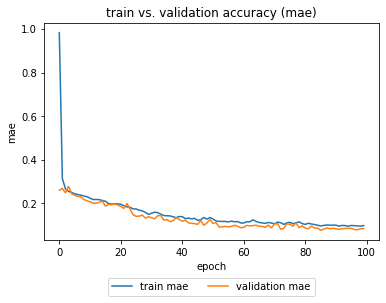

In [26]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

#### Prediction

In [27]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [28]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [29]:
# Next, we put all the outputs with recovered trend into a dictionary data_final.
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


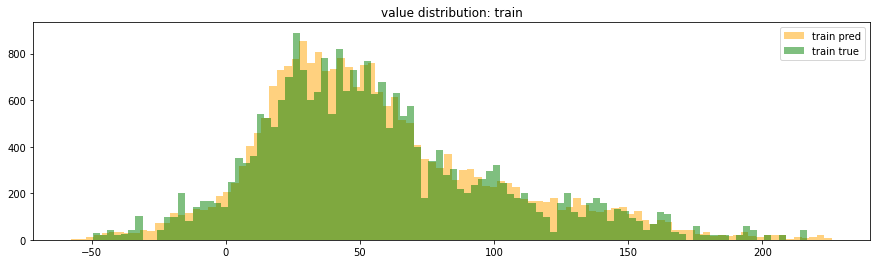

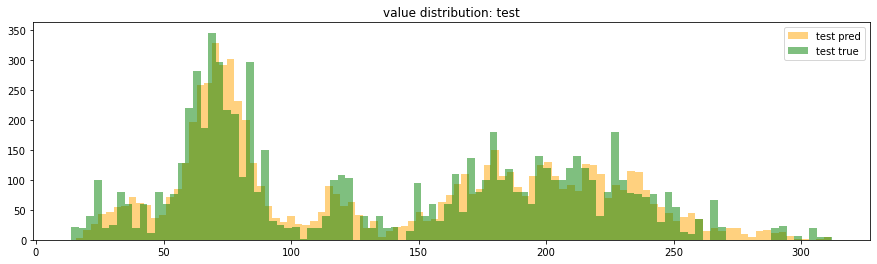

In [30]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

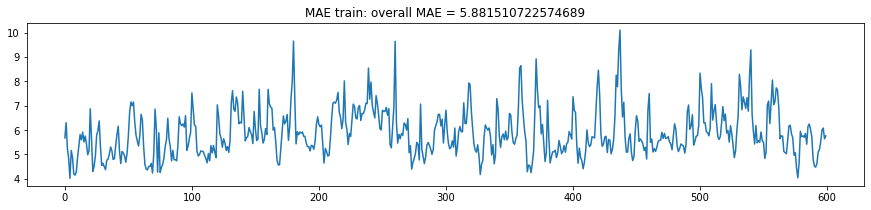

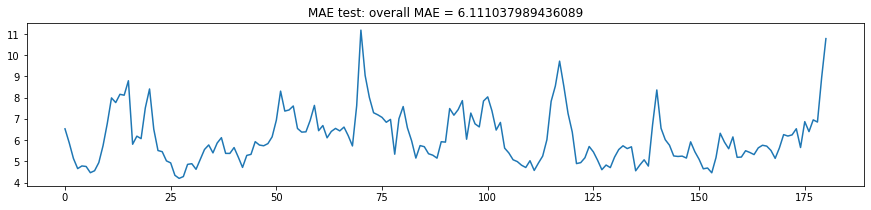

In [31]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

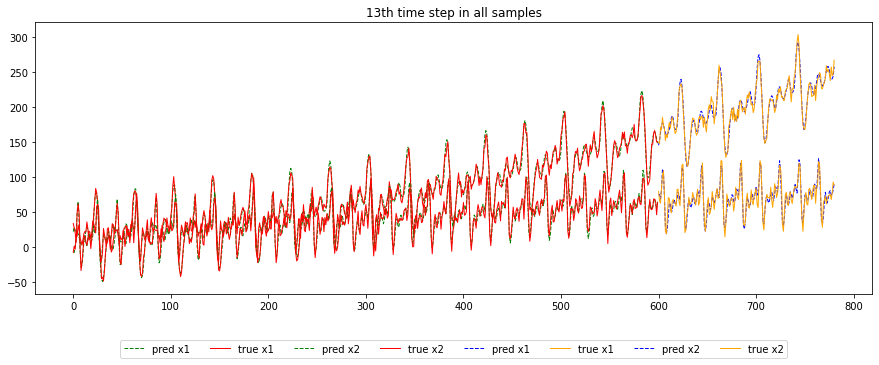

In [32]:

ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

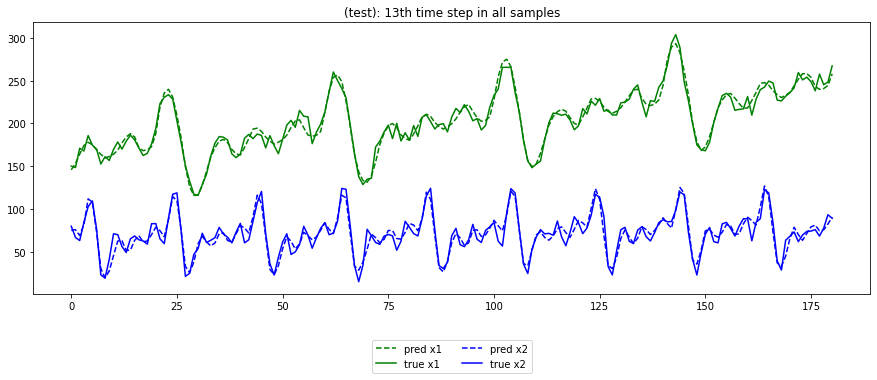

In [33]:
# Take a closer look at the prediction on test set
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()